## Accessing NOAA U.S. NClimGrid with the Planetary Computer STAC API

The [NOAA U.S. Climate Gridded Dataset (NClimGrid)](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00332) consists of four climate variables derived from the Global Historical Climatology Network Daily dataset (GHCNd): 
- maximum temperature, 
- minimum temperature, 
- average temperature, 
- and precipitation. 

Values in a 1/24 degree lat/lon (nominal 5x5 kilometer) grid are provided for the contiguous United States (CONUS). Daily data are available from 1951 to the present; monthly data span from 1895 to present. Images are stored in cloud-optimized GeoTIFF (COG) format.


In this notebook, we'll demonstrate how to access and work with NClimGrid Monthly data through the Planetary Computer API. Documentation for this dataset is available at the [Planetary Computer Data Catalog](https://planetarycomputer.microsoft.com/dataset/group/noaa-nclimgrid).



### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to the user account API key.

In [1]:
import odc.stac
import planetary_computer as pc
from pystac_client import Client

import rich.table

### Query for available data
In this notebook, we'll demonstrate how to access and work with NClimGrid Monthly data. We select times within the monthly data temporal extent (1951 to the present). The STAC API locates the available STAC items within the specified parameter. 

In [2]:
# Open the Planetary Computer STAC API
URL = "https://pct-apis-staging.westeurope.cloudapp.azure.com/stac/"
catalog = Client.open(URL)
catalog

<Client id=microsoft-pc>

In [3]:
# Select time of interest
datetimes = [
    "2020-01-01",
    "2020-04-01",
    "2020-07-01",
    "2020-10-01",
]

items = dict()

# Fetch the collection of interest and print availabe items
for datetime in datetimes:
    print(f"Fetching {datetime}")
    search = catalog.search(
        collections=["noaa-nclimgrid-monthly"],
        datetime=datetime,
    )
    item = search.get_all_items()[0]
    items[datetime] = pc.sign(item)

print(items)

Fetching 2020-01-01
Fetching 2020-04-01
Fetching 2020-07-01
Fetching 2020-10-01
{'2020-01-01': <Item id=nclimgrid-202001>, '2020-04-01': <Item id=nclimgrid-202004>, '2020-07-01': <Item id=nclimgrid-202007>, '2020-10-01': <Item id=nclimgrid-202010>}


### Available Assets

Let's display the available assets and metadata for the NClimGrid Monthly items. 

In [4]:
# Assets
t = rich.table.Table("Key", "Value")
for key, asset in items["2020-01-01"].assets.items():
    t.add_row(key, asset.title)
t

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key              ┃ Value                                         ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ prcp             │ Monthly Precipitation (mm)                    │
│ tavg             │ Monthly Average Temperature (degree Celsius)  │
│ tmax             │ Monthly Maximmum Temperature (degree Celsius) │
│ tmin             │ Monthly Minimum Temperature (degree Celsius)  │
│ prcp_source      │ Monthly Precipitation Source Data             │
│ tavg_source      │ Monthly Average Temperature Source Data       │
│ tmax_source      │ Monthly Maximmum Temperature Source Data      │
│ tmin_source      │ Monthly Minimum Temperature Source Data       │
│ tilejson         │ TileJSON with default rendering               │
│ rendered_preview │ Rendered preview                              │
└──────────────────┴───────────────────────────────────────────────┘

In [5]:
# Metadata
t = rich.table.Table("Key", "Value")
for k, v in sorted(items["2020-01-01"].properties.items()):
    t.add_row(k, str(v))
t

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key            ┃ Value                                                           ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ created        │ 2022-09-07T19:48:28.906953Z                                     │
│ datetime       │ None                                                            │
│ end_datetime   │ 2020-01-31T23:59:59Z                                            │
│ proj:epsg      │ 4326                                                            │
│ proj:shape     │ [596, 1385]                                                     │
│ proj:transform │ [0.04166667, 0.0, -124.70833333, 0.0, -0.04166667, 49.37500127] │
│ start_datetime │ 2020-01-01T00:00:00Z                                            │
└────────────────┴─────────────────────────────────────────────────────────────────┘

### Loading the land cover data
Now let's load STAC items into an xarray dataset using [odc-stac](https://github.com/opendatacube/odc-stac). Location coordinates are centered to CONUS (39.50°N, 98.35°W). 

In [6]:
latitude = 39.50
longitude = -98.35
buffer = 35
bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]

ds = odc.stac.load(
    items.values(),
    crs="EPSG:4326",
    bbox=bbox,
    resolution=0.0416,
)
ds

<xarray.Dataset>
Dimensions:      (time: 4, latitude: 1683, longitude: 1684)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-16T11:59:59.500000 ... 2020-10...
  * latitude     (latitude) float64 74.48 74.44 74.4 74.36 ... 4.597 4.555 4.514
  * longitude    (longitude) float64 -133.3 -133.3 -133.3 ... -63.38 -63.34
    spatial_ref  int32 4326
Data variables:
    prcp         (time, latitude, longitude) uint16 0 0 0 0 0 0 ... 0 0 0 0 0 0
    tavg         (time, latitude, longitude) uint16 0 0 0 0 0 0 ... 0 0 0 0 0 0
    tmax         (time, latitude, longitude) uint16 0 0 0 0 0 0 ... 0 0 0 0 0 0
    tmin         (time, latitude, longitude) uint16 0 0 0 0 0 0 ... 0 0 0 0 0 0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

### Displaying the data



In [7]:
# Libaries for drawing maps
import cartopy.crs as ccrs
import cartopy

# Libaries for making plots
import matplotlib.pyplot as plt


from geogif import gif

Let's display NClimGrid Monthly precipitation in April 2020 and temperature throughout the 2020 midseasonal months (January, April, July, October). 

Text(0.5, 1.0, 'NClimGrid Monthly Precipitation(mm) (01-04-2020)')

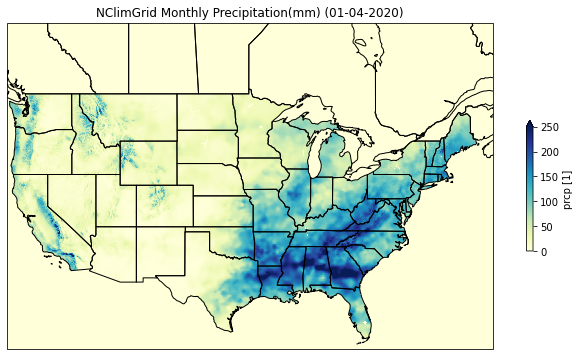

In [8]:
extent = [-125, -65, 24, 50.5]
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Mercator())

prcp = ds.prcp.sel(time="2020-04-01", method="nearest")

plt = prcp.plot(
    ax=ax,
    cmap="YlGnBu",
    cbar_kwargs={"shrink": 0.4},
    transform=ccrs.PlateCarree(),
    vmax=250,
    vmin=0,
)

ax.set_extent(extent)
ax.add_feature(cartopy.feature.STATES)
ax.set_title("NClimGrid Monthly Precipitation(mm) (01-04-2020)")

Midseasonal months (January, April, July, October) show temperature change between seasons. 

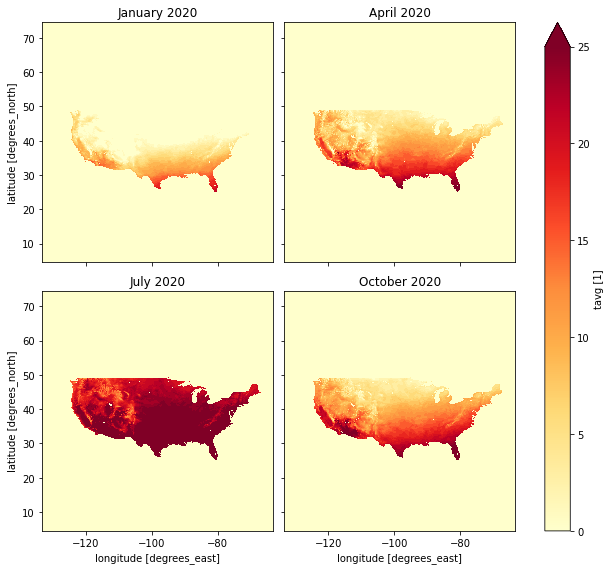

In [9]:
plt = ds.tavg.plot(cmap="YlOrRd", col="time", col_wrap=2, size=4, vmax=25, vmin=0)

months = ds.tavg.time.to_pandas().dt.strftime("%B %Y")

for ax, month in zip(plt.axes.flat, months):
    ax.set_title(month)

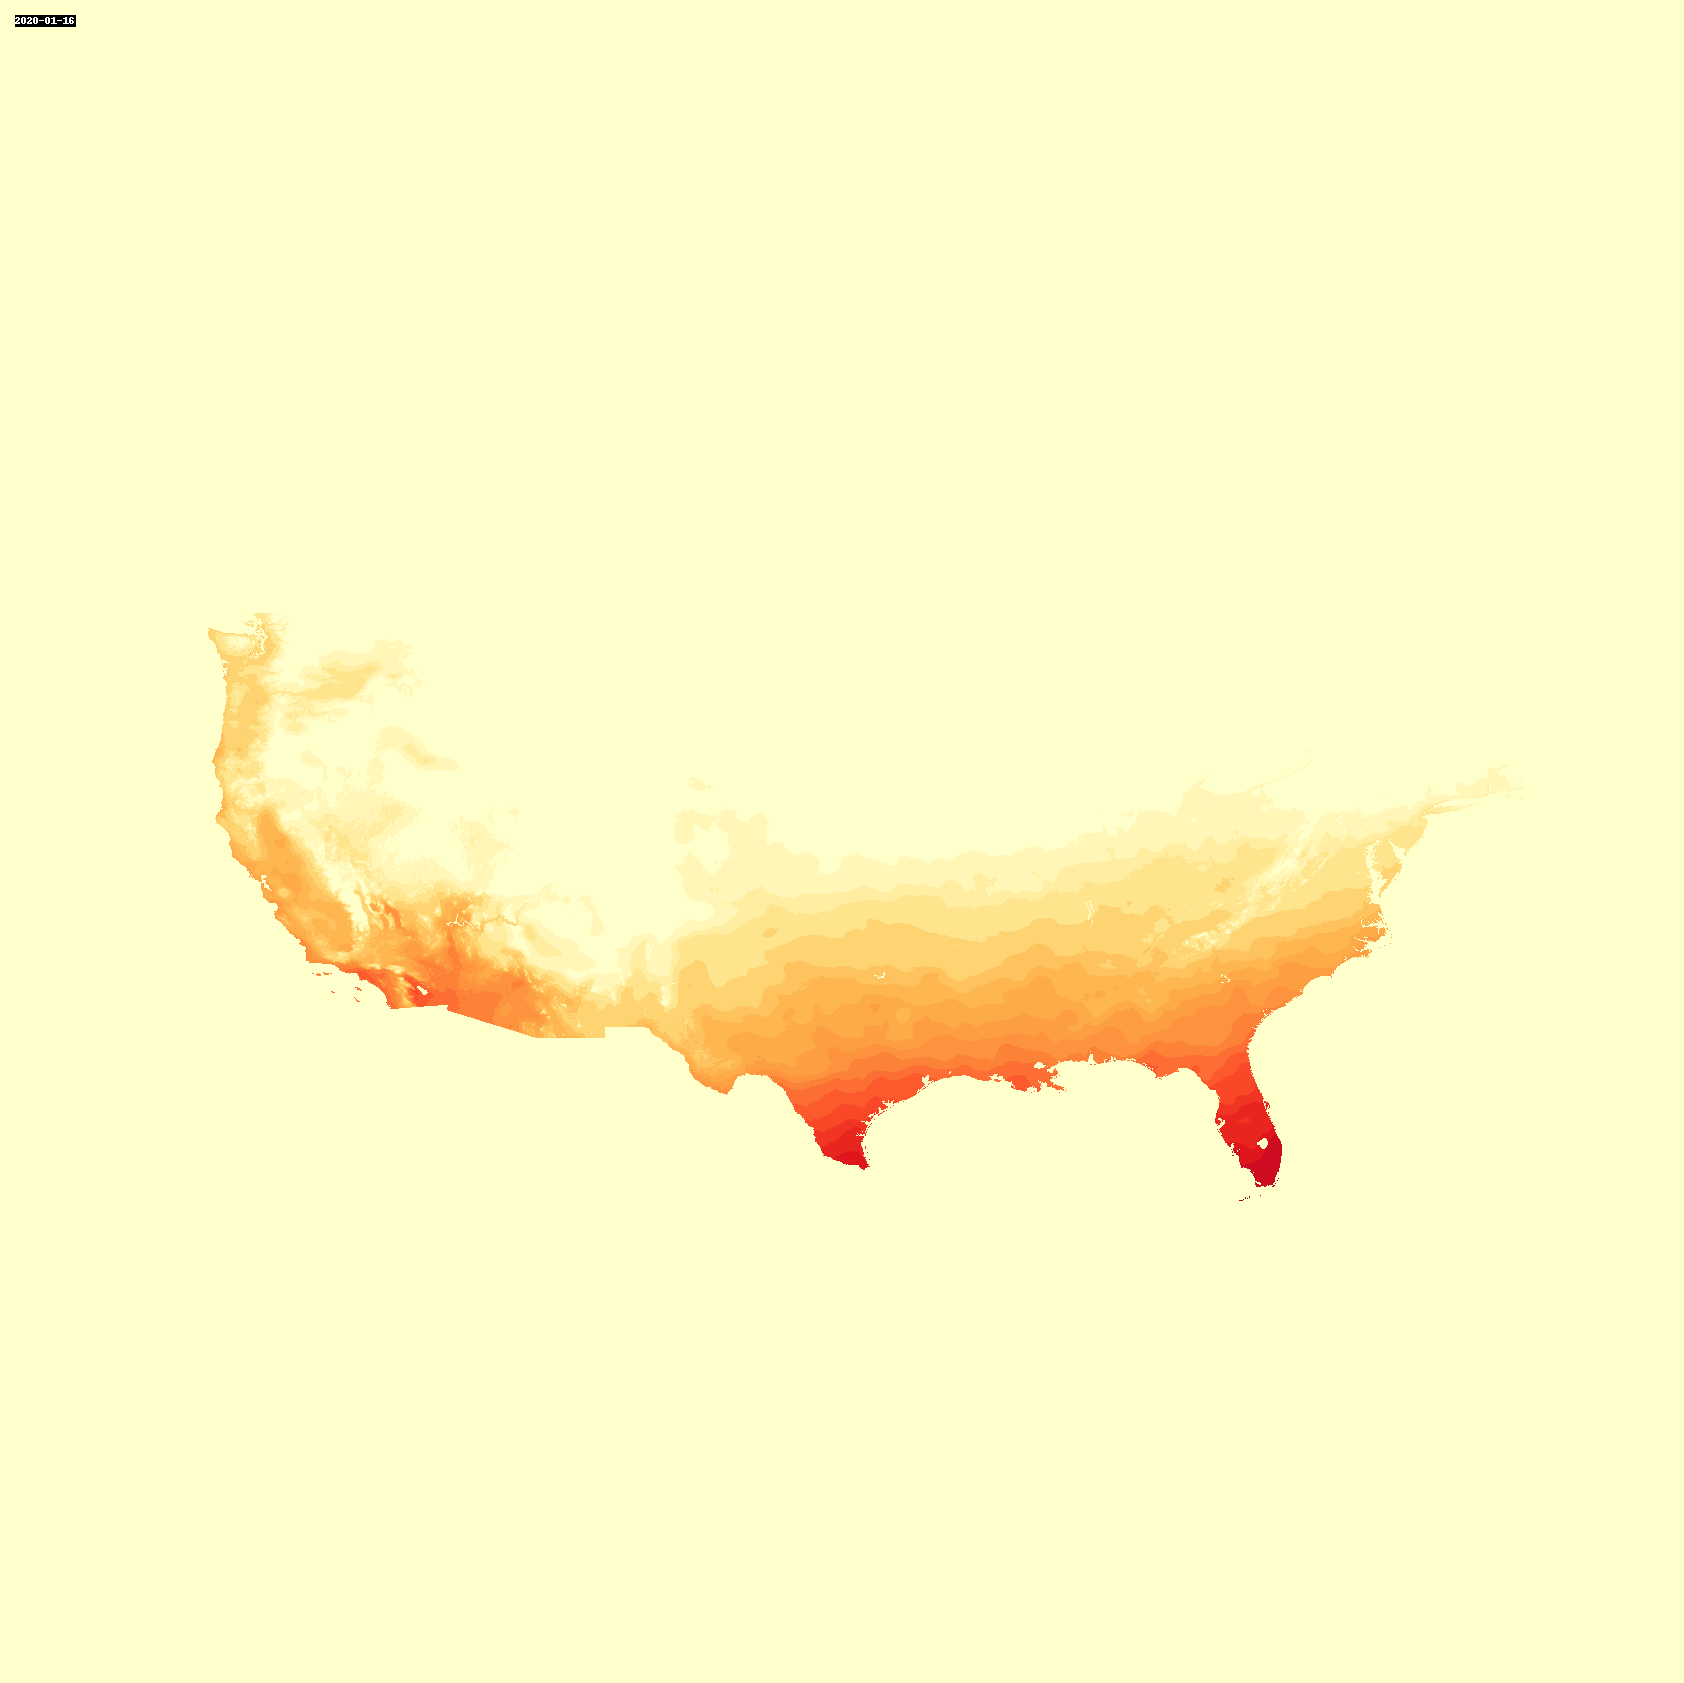

In [13]:
gif(ds.tavg, fps=2, cmap="YlOrRd")